# Mobile Plan Comparative Analysis

#### Objective: To analyze clients' behavior and determine which prepaid plan brings in more revenue

## Description of the Data

Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.
The users table (data on users):

    user_id — unique user identifier
    first_name — user's name
    last_name — user's last name
    age — user's age (years)
    reg_date — subscription date (dd, mm, yy)
    churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)
    city — user's city of residence
    plan — calling plan name

The calls table (data on calls):

    id — unique call identifier
    call_date — call date
    duration — call duration (in minutes)
    user_id — the identifier of the user making the call

The messages table (data on texts):

    id — unique text message identifier
    message_date — text message date
    user_id — the identifier of the user sending the text

The internet table (data on web sessions):

    id — unique session identifier
    mb_used — the volume of data spent during the session (in megabytes)
    session_date — web session date
    user_id — user identifier

The plans table (data on the plans):

    plan_name — calling plan name
    usd_monthly_fee — monthly charge in US dollars
    minutes_included — monthly minute allowance
    messages_included — monthly text allowance
    mb_per_month_included — data volume allowance (in megabytes)
    usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
    usd_per_message — price per text after exceeding the package limits
    usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

## Step 1. Open the data file and study the general information

In [ ]:
import pandas as pd
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import scipy
from scipy import stats as st

In [ ]:

spreadsheet_id = '1EVGFrzc_zPw8NumvU1VSkG2fpunGT0lJn9gj_k2zwkY'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
calls = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1nCZXmNI_29fv719U5nqcv3YtoBaTaxqgOymehPxL38k'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
internet = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1djQbiyemfHn3ln7OyDSJMz8FBWAIPwdbqq-DCOXW7QI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
messages = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1kpEjXWmeUpSrWdP9qOjjFE9otyz8TkfD64XjzI2FtSY'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
plans = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1ZJu1X3FgP2t7vl60TnIiVHD6fTi6_57fU2UJVBB3kw4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
users = pd.read_csv(BytesIO(r.content))

In [ ]:
display(calls.info())
display(calls.head())
display(calls.describe())

> -  **Call_date** should be changed to datetime format
> - **Duration** should be changed to int datatype since the company rounds seconds to minutes
> - There are no missing values
> - Average call duration is about 6-7 minutes
> - Maximum call duration  is about 38 minutes

In [ ]:
display(internet.info())
display(internet.head())
display(internet.describe())

> - **Session_date** should be changed to datetime format
> - For web traffic, total monthly use is rounded up and not individual web sessions
> - There are no missing values
> - Average **mb_used** is 366

In [ ]:
display(messages.info())
display(messages.head())
display(messages.describe())

> -  **Message_date** needs to be changed to datetime
> - There are no missing values

In [ ]:
display(plans.info())
display(plans.head())
display(plans.describe())

> - No missing values and the columns are on their right datatypes

In [ ]:
display(users.info())
display(users.head())
display(users.describe())

> - **Reg_date** and **churn_date** needs to be changed to datetime dtype
> - There seems to be a lot of missing values under the **churn_date** column. According to the description of the data, churn_date is the date the user stopped using the service. If the value is missing, the calling plan was being used when the data was generated.
> - Average users are 45 years old


### Conclusion


> - Looking through the data, there's not a lot of missing values. 
> -Churn_date column has the only missing values. 
> - Several columns have incorrect datatypes especially the date columns which currently have the object dataytype. We need to do some data preprocessing, data type replacement and replace missing values when necessary.

## Step 2. Prepare the data

> - Convert the data to the necessary types
> - Find and eliminate errors in the data

For each user, find:
> - The number of calls made and minutes used per month
> - The number of text messages sent per month
> - The volume of data per month
> - The monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

#### Changing data types

In [ ]:
#Casting datetime to date columns
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

In [ ]:
#Rounding up  all calls to minutes
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

> - As per company policy, I rounded all the calls to minutes 

#### Checking for duplicates

In [ ]:
display(calls.duplicated().sum())
display(internet.duplicated().sum())
display(messages.duplicated().sum())
display(plans.duplicated().sum())
display(users.duplicated().sum())

#### Missing Values Replacement

> - As we found out earlier, the **churn_date** column under <em>Users df</em> has the only one with missing values. Let's go ahead and deal with it. 
> - According to the company, there are missing values because the calling plan was being used when the data was generated. Because of that I'm filling the missing values with <em>not available</em>.

In [ ]:
users['churn_date']= users['churn_date'].fillna('not available')

In [ ]:
calls.info()

In [ ]:
calls.loc[calls['duration']==0]

In [ ]:
#categorizing call duration
calls['type'] = np.where(calls['duration']== 0,'Missed', 'Connected')
display(calls.sample(10))
display(calls['type'].value_counts())

In [ ]:
calls['duration'].hist()
plt.title('Call Duration')
plt.show()


> - I decided to categorize calls that had zero minutes to **<em>Missed</em>** and **<em>Connected</em>** for the rest 
> - As we can see there are 26834 missed calls

In [ ]:
internet.loc[internet['mb_used']== 0]

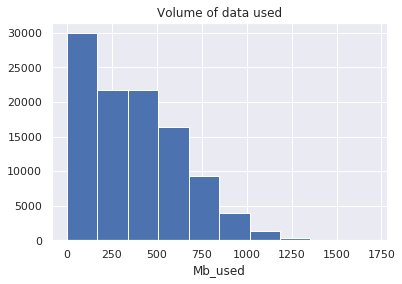

In [104]:
internet['mb_used'].hist()
plt.title('Volume of data used')
plt.xlabel('Mb_used')
plt.show()

> There are 13747 users that did not use their data. It could be that they're always connected to WIFI or out of the country

#### Calculations 

**<em>Calls per month and minutes used per month</em>**

In [86]:
calls['month'] = calls['call_date'].dt.month

In [87]:
calls_per_month = calls.groupby(['user_id','month']).agg({'id':'count'}).rename(columns={'id':'calls per month'})
display(calls_per_month)

#Minutes used per month
mins_used = calls.groupby(['user_id', 'month']).agg({'duration':'sum'}).rename(columns={'duration': 'mins used'})
display(mins_used)

calls per month
user_id month                 
1000    12                  16
1001    8                   27
        9                   49
        10                  65
        11                  64
...                        ...
1498    12                  39
1499    9                   41
        10                  53
        11                  45
        12                  65

[2258 rows x 1 columns]

mins used
user_id month           
1000    12           124
1001    8            182
        9            315
        10           393
        11           426
...                  ...
1498    12           339
1499    9            346
        10           385
        11           308
        12           496

[2258 rows x 1 columns]

**<em>Messages sent per month</em>**

In [88]:
messages['month'] = messages['message_date'].dt.month

In [89]:
msgs_per_month = messages.groupby(['user_id', 'month']).agg({'id':'count'}).rename(columns={'id':'msgs per month'})
display(msgs_per_month.head())

msgs per month
user_id month                
1000    12                 11
1001    8                  30
        9                  44
        10                 53
        11                 36

**<em>Data per month</em>**

In [90]:
internet['month']= internet['session_date'].dt.month

In [91]:
data_per_month = internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).\
                rename(columns={'mb_used':'data in mb used'})
data_per_month['data in gb per month'] = np.ceil((data_per_month['data in mb used'].values) / 1024).astype(int)
display(data_per_month.head())

data in mb used  data in gb per month
user_id month                                       
1000    12             1901.47                     2
1001    8              6919.15                     7
        9             13314.82                    14
        10            22330.49                    22
        11            18504.30                    19

In [18]:
data_per_month.describe()

,data in mb used,data in gb per month
count,2277.000000,2277.000000
mean,16882.197501,17.372859
std,7869.784848,7.869052
min,92.310000,1.000000
25%,12347.720000,13.000000
50%,16873.740000,17.000000
75%,21041.520000,22.000000
max,70931.590000,71.000000


In [19]:
user_plan = users[['user_id', 'plan', 'city']]

In [20]:
monthly_usage = pd.concat([calls_per_month, mins_used, msgs_per_month, data_per_month],axis=1).\
                reset_index().merge(user_plan, on='user_id')


> - We were able to calculate the average usage monthly and created a separated dataframe so we can look at it closely. Now we need to calculate the monthly revenue.

In [21]:
display(monthly_usage)
display(monthly_usage.describe())

,user_id,month,calls per month,mins used,msgs per month,data in mb used,data in gb per month,plan,city
0,1000,12,16.0,124.0,11.0,1901.47,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,27.0,182.0,30.0,6919.15,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,49.0,315.0,44.0,13314.82,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,65.0,393.0,53.0,22330.49,23.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,64.0,426.0,36.0,18504.30,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...,...
2288,1498,12,39.0,339.0,NaN,23137.69,24.0,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA"
2289,1499,9,41.0,346.0,NaN,12984.76,13.0,surf,"Orlando-Kissimmee-Sanford, FL MSA"
2290,1499,10,53.0,385.0,NaN,19492.43,20.0,surf,"Orlando-Kissimmee-Sanford, FL MSA"
2291,1499,11,45.0,308.0,NaN,16813.83,17.0,surf,"Orlando-Kissimmee-Sanford, FL MSA"


,user_id,month,calls per month,mins used,msgs per month,data in mb used,data in gb per month
count,2293.000000,2293.000000,2258.000000,2258.000000,1806.000000,2277.000000,2277.000000
mean,1246.075883,9.172700,60.998671,435.937555,42.110188,16882.197501,17.372859
std,143.051927,2.496386,31.770869,231.972343,33.122931,7869.784848,7.869052
min,1000.000000,1.000000,1.000000,0.000000,1.000000,92.310000,1.000000
25%,1122.000000,8.000000,39.000000,275.000000,17.000000,12347.720000,13.000000
50%,1245.000000,10.000000,60.000000,429.000000,34.000000,16873.740000,17.000000
75%,1368.000000,11.000000,80.000000,574.750000,59.000000,21041.520000,22.000000
max,1499.000000,12.000000,205.000000,1510.000000,266.000000,70931.590000,71.000000


In [22]:
monthly_usage = monthly_usage.merge(plans, left_on = 'plan', right_on ='plan_name')
monthly_usage.tail()
monthly_usage.head()

,user_id,month,calls per month,mins used,msgs per month,data in mb used,data in gb per month,plan,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12,16.0,124.0,11.0,1901.47,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70,7,0.01,0.01,ultimate
1,1006,11,2.0,10.0,15.0,2068.37,3.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,ultimate
2,1006,12,9.0,59.0,139.0,32118.82,33.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30720,3000,70,7,0.01,0.01,ultimate
3,1008,10,71.0,476.0,21.0,17106.99,18.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,ultimate
4,1008,11,63.0,446.0,37.0,23676.72,24.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30720,3000,70,7,0.01,0.01,ultimate


In [23]:
# checking for missing values
monthly_usage.isnull().sum()

user_id                    0
month                      0
calls per month           35
mins used                 35
msgs per month           487
data in mb used           16
data in gb per month      16
plan                       0
city                       0
messages_included          0
mb_per_month_included      0
minutes_included           0
usd_monthly_pay            0
usd_per_gb                 0
usd_per_message            0
usd_per_minute             0
plan_name                  0
dtype: int64

In [24]:
# filling in missing values with 0
monthly_usage= monthly_usage.fillna(0)

> -  As we can see, we had missing values but since it's based on customer usage, it makes sense to fill it in with 0. It might be because the user only used certain features on their plan. 

**<em>Monthly revenue from each user</em>**

In [25]:
# Calculating revenue
monthly_usage['call_cost'] = monthly_usage.apply(lambda x: max(0, x['mins used'] - x['minutes_included'])\
                                    * x['usd_per_minute'], axis = 1)
monthly_usage['message_cost'] = monthly_usage.apply(lambda x: max(0, x['msgs per month'] \
                                  - x['messages_included']) * x['usd_per_message'], axis = 1)
monthly_usage['data_cost'] = monthly_usage.apply(lambda x: np.ceil(max(0, x['data in mb used'] \
                                  - x['mb_per_month_included'])/1024)*x['usd_per_gb'],  axis = 1)
monthly_usage['monthly_rev'] = monthly_usage['message_cost'] + monthly_usage['call_cost']\
                                    + monthly_usage['data_cost'] + monthly_usage['usd_monthly_pay']


In [26]:
monthly_usage['monthly_rev'].mean()

64.3511469690362

In [27]:
total_revenue_month_plan = monthly_usage.groupby(['plan','month'])['monthly_rev'].sum().reset_index()

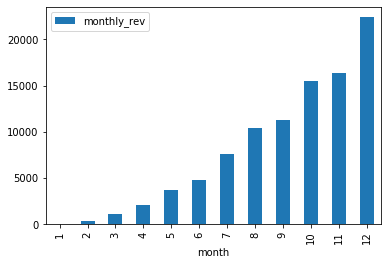

In [28]:
total_revenue_month_plan[total_revenue_month_plan['plan'] == 'surf'].plot(y='monthly_rev', x='month', kind='bar')
plt.show()

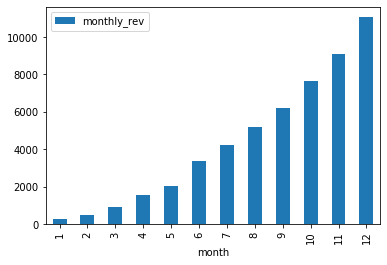

In [29]:
total_revenue_month_plan[total_revenue_month_plan['plan'] == 'ultimate'].plot(y='monthly_rev', x='month', kind='bar')
plt.show()

> - Average monthly revenue is 64
> - Revenue under Surf is significantly higher than Ultimate
> - Revenue tends to be higher in the last quarter for both plans
> - Surf revenue being higher could be due, in part, to the users' tendency to go over on their plan more than Ultimate users

## Step 3. Analyze the data 

Now we are going to look closely at the 2 plans and compare them. Let's create 2 separate dataframe

In [30]:
surf_usage = monthly_usage[monthly_usage['plan']=='surf']\
                [['user_id', 'month','mins used',\
                  'msgs per month', 'data in mb used',\
                  'data in gb per month', 'monthly_rev']]

ultimate_usage = monthly_usage[monthly_usage['plan']=='ultimate']\
                    [['user_id', 'month','mins used',\
                      'msgs per month', 'data in mb used',\
                      'data in gb per month', 'monthly_rev']]
                           

In [31]:
surf_usage.describe()

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,1242.755245,9.182454,428.749523,31.159568,16558.283490,17.037508,60.706408
std,139.227939,2.468199,234.453150,33.566717,8013.513327,8.016395,55.388042
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,1120.000000,8.000000,272.000000,3.000000,11986.520000,12.000000,20.000000
50%,1245.000000,10.000000,425.000000,24.000000,16829.310000,17.000000,40.360000
75%,1358.000000,11.000000,576.000000,47.000000,20999.610000,21.000000,80.360000
max,1499.000000,12.000000,1510.000000,266.000000,70931.590000,71.000000,590.370000


In [32]:
ultimate_usage.describe()

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,1253.330556,9.151389,430.450000,37.551389,17214.699694,17.719444,72.313889
std,150.915644,2.558495,240.508762,34.767179,7851.897435,7.865289,11.395108
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,70.000000
25%,1126.000000,8.000000,260.000000,7.000000,12666.955000,13.000000,70.000000
50%,1241.500000,10.000000,424.000000,30.000000,16858.340000,17.000000,70.000000
75%,1401.000000,11.000000,565.250000,61.000000,21014.527500,22.000000,70.000000
max,1497.000000,12.000000,1369.000000,166.000000,46595.330000,47.000000,182.000000


> - Looking at the data, there are definitely more users of Surf plan than Ultimate plan , more than twice the amount.
> - The average monthly revenue for Ultimate is not as large as expected despite being the more expensive plan, especially when compared to the average revenue of Surf.
> - More users go over their plan under Surf which in turn drives their revenue up
> - Users barely go over the alloted plan under Ultimate

### Calculate mean, variance and standard deviation and histograms

**<em>Calls</em>**

In [33]:
pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


Text(0.5, 0.98, 'Surf Plan')

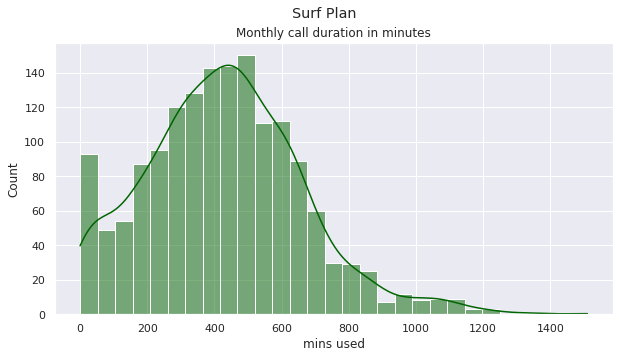

In [34]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.histplot(data =surf_usage, x='mins used',color= 'darkgreen', kde=True)\
            .set_title('Monthly call duration in minutes')
plt.suptitle('Surf Plan')
plt.show()



Text(0.5, 0.98, 'Ultimate Plan')

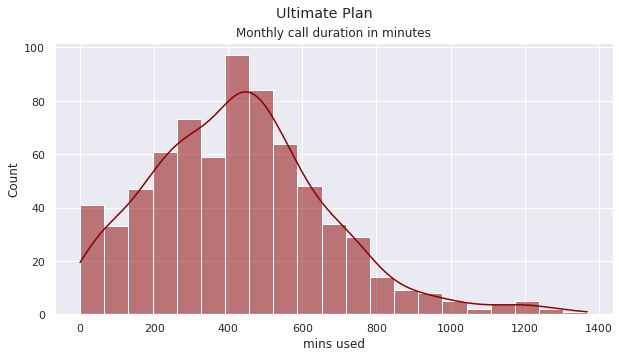

In [35]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.histplot(data =ultimate_usage, x='mins used',color= 'darkred', kde=True)\
            .set_title('Monthly call duration in minutes')
plt.suptitle('Ultimate Plan')
plt.show()


> - Average  for both Surf and Ultimate is 428 and 430, respectively, which is really close and has a standard deviation with 234 and 240
> - Distribution is close to normal as the values for both median and mean are really close to each other

In [36]:
monthly_usage.groupby('plan')['mins used'].agg(['mean', 'var', 'std'])

,mean,var,std
plan,,,
surf,428.749523,54968.279461,234.453150
ultimate,430.450000,57844.464812,240.508762


Surf plan limit is 500 minutes per month. Let's take a look how many people exceeded their minutes

In [37]:
display(surf_usage.query('`mins used` > 500'))
display(surf_usage.query('`mins used` == 0'))
surf_usage['mins used'].describe()

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
728,1003,12,1104.0,50.0,27044.14,28.0,158.12
740,1007,10,645.0,59.0,37885.63,38.0,244.62
741,1007,11,524.0,48.0,24334.00,25.0,110.72
742,1007,12,617.0,50.0,29069.28,30.0,163.51
743,1009,5,534.0,0.0,20389.40,21.0,71.02
...,...,...,...,...,...,...,...
2247,1489,10,518.0,84.0,14695.08,15.0,21.56
2256,1491,10,585.0,51.0,8480.09,9.0,22.58
2266,1494,10,616.0,38.0,14498.50,15.0,23.48
2267,1494,11,509.0,35.0,18405.82,19.0,50.27


,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
961,1080,8,0.0,31.0,20519.74,21.0,80.00
962,1080,9,0.0,64.0,25499.72,26.0,120.42
963,1080,10,0.0,59.0,30161.57,31.0,170.27
964,1080,11,0.0,50.0,33559.88,34.0,200.00
965,1080,12,0.0,61.0,24543.42,25.0,110.33
992,1089,12,0.0,27.0,16597.91,17.0,40.00
1003,1094,10,0.0,0.0,1728.71,2.0,20.00
1117,1121,11,0.0,1.0,1236.65,2.0,20.00
1118,1121,12,0.0,97.0,66863.89,67.0,531.41
1146,1131,5,0.0,18.0,6468.11,7.0,20.00


count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: mins used, dtype: float64

> - 566 users exceeded their minutes
> - 1510 mins is the max number of minutes a user had used. That's 3 times the alloted minutes for the plan and creates profit for the company
> - 29 users did not use their minutes at all

In [38]:
display(ultimate_usage.query('`mins used` > 3000'))
display(ultimate_usage.query('`mins used` == 0'))
ultimate_usage['mins used'].describe()

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev


,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
16,1028,2,0.0,12.0,12591.91,13.0,70.0
161,1108,12,0.0,0.0,233.17,1.0,70.0
304,1204,11,0.0,42.0,21346.95,22.0,70.0
305,1204,12,0.0,78.0,36730.05,37.0,112.0
326,1224,6,0.0,5.0,2966.21,3.0,70.0
426,1311,6,0.0,0.0,1498.83,2.0,70.0
561,1407,11,0.0,1.0,290.06,1.0,70.0
704,1482,10,0.0,2.0,0.00,0.0,70.0


count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: mins used, dtype: float64

> - As we can see, no one exceeded their minutes for the Ultimate plan
> - Eight users did not use their minutes at all
> - The max number of minutes a user had used is 1369, barely half of what the Ultimate plan offered

**<em>Messages</em>**

Text(0.5, 0.98, 'Surf Plan')

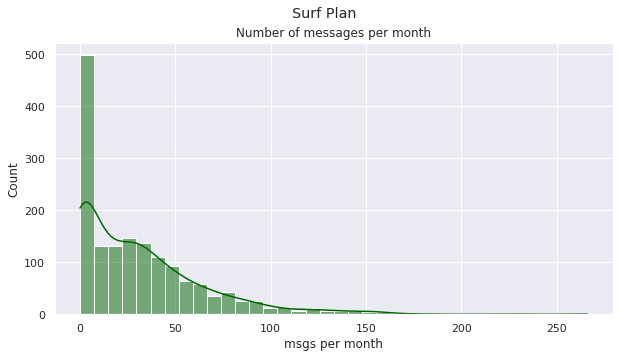

In [39]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.histplot(data =surf_usage, x='msgs per month',color= 'darkgreen', kde=True)\
            .set_title('Number of messages per month')
plt.suptitle('Surf Plan')

Text(0.5, 0.98, 'Ultimate Plan')

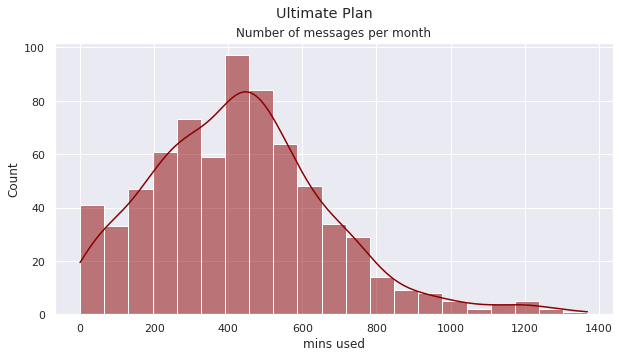

In [40]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.histplot(data =ultimate_usage, x='mins used',color= 'darkred', kde=True).set_title('Number of messages per month')
plt.suptitle('Ultimate Plan')

In [41]:
monthly_usage.groupby('plan')['msgs per month'].agg(['mean','var', 'std'])

,mean,var,std
plan,,,
surf,31.159568,1126.724522,33.566717
ultimate,37.551389,1208.756744,34.767179


> - The histogram for both the Ultimate and Surf plans is right skewed
> - Standard deviation is almost the same as mean
> - Surf users sent less messages than ultimate plan users, which makes sense because they have a lower limit and try to avoid exceeding the messaging limit

In [42]:
display(surf_usage.query('`msgs per month`> 50'))
display(surf_usage.query('`msgs per month` ==0'))
surf_usage['msgs per month'].describe()

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
722,1001,10,393.0,53.0,22330.49,23.0,90.09
738,1007,8,456.0,51.0,24439.88,25.0,110.03
740,1007,10,645.0,59.0,37885.63,38.0,244.62
763,1014,12,1114.0,64.0,7792.41,8.0,38.84
764,1015,12,96.0,68.0,17495.12,18.0,50.54
...,...,...,...,...,...,...,...
2248,1489,11,429.0,91.0,18266.25,19.0,51.23
2249,1489,12,394.0,86.0,15321.07,16.0,21.08
2252,1491,6,394.0,54.0,11034.31,12.0,20.12
2253,1491,7,463.0,64.0,7833.29,8.0,20.42


,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
743,1009,5,534.0,0.0,20389.40,21.0,71.02
744,1009,6,823.0,0.0,18845.90,19.0,69.69
745,1009,7,880.0,0.0,30421.65,31.0,181.40
746,1009,8,731.0,0.0,24557.52,25.0,116.93
747,1009,9,776.0,0.0,20962.40,21.0,88.28
...,...,...,...,...,...,...,...
2288,1498,12,339.0,0.0,23137.69,24.0,100.00
2289,1499,9,346.0,0.0,12984.76,13.0,20.00
2290,1499,10,385.0,0.0,19492.43,20.0,70.00
2291,1499,11,308.0,0.0,16813.83,17.0,40.00


count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: msgs per month, dtype: float64

> - 340 users exceeded their messaging limit
> - 351 did not use messaging at all
> - 266 is the max number of messages a user had sent. That's 5 times the alloted number of messages

In [43]:
display(ultimate_usage.query('`msgs per month`> 1000'))
display(ultimate_usage.query('`msgs per month` ==0'))
ultimate_usage['msgs per month'].describe()

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev


,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
60,1041,3,23.0,0.0,1586.39,2.0,70.0
61,1041,4,453.0,0.0,20601.58,21.0,70.0
62,1041,5,407.0,0.0,18259.46,19.0,70.0
63,1041,6,311.0,0.0,20033.17,21.0,70.0
64,1041,7,533.0,0.0,23400.72,24.0,70.0
...,...,...,...,...,...,...,...
714,1493,8,373.0,0.0,14137.82,15.0,70.0
715,1493,9,529.0,0.0,14991.17,15.0,70.0
716,1493,10,450.0,0.0,16329.57,17.0,70.0
717,1493,11,500.0,0.0,15630.78,16.0,70.0


count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: msgs per month, dtype: float64

> - As we can see from above, no one exceeded their messaging limit under the Ultimate plan
> - 136 users did not use their messaging at all
> - 166 is the max number of messages a user had used, which is barely 20% of the plan

**<em>Data</em>**

Text(0.5, 0.98, 'Surf Plan')

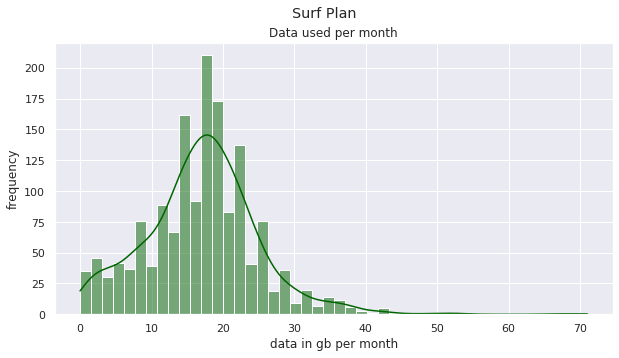

In [44]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.histplot(data =surf_usage, x='data in gb per month',color= 'darkgreen', kde=True).set_title('Data used per month')
plt.ylabel('frequency')
plt.suptitle('Surf Plan')
plt.show()

Text(0.5, 0.98, 'Ultimate Plan')

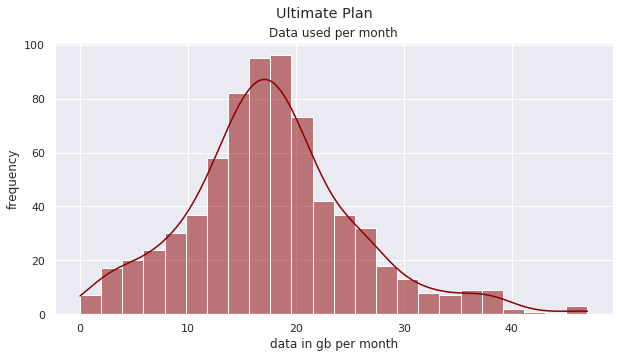

In [45]:
plt.figure(figsize = (10,5))
sns.set(style='darkgrid')
sns.histplot(data =ultimate_usage, x='data in gb per month',color= 'darkred', kde=True).set_title('Data used per month')
plt.ylabel('frequency')
plt.suptitle('Ultimate Plan')
plt.show()

In [46]:
monthly_usage.groupby('plan')['data in gb per month'].agg(['mean','var', 'std'])

,mean,var,std
plan,,,
surf,17.037508,64.262587,8.016395
ultimate,17.719444,61.862765,7.865289


> - Graphs for both Surf and Ultimate have similar distribution
> - Mean and median are almost identical which is a sign that the distribution is close to normal

In [47]:
display(surf_usage.query('`data in gb per month` > 15'))
display(surf_usage.query('`data in gb per month` == 0'))
surf_usage['data in gb per month'].describe()

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
722,1001,10,393.0,53.0,22330.49,23.0,90.09
723,1001,11,426.0,36.0,18504.30,19.0,60.00
724,1001,12,412.0,44.0,19369.18,20.0,60.00
726,1002,11,386.0,32.0,19345.08,20.0,60.00
728,1003,12,1104.0,50.0,27044.14,28.0,158.12
...,...,...,...,...,...,...,...
2287,1498,11,223.0,0.0,19168.55,20.0,60.00
2288,1498,12,339.0,0.0,23137.69,24.0,100.00
2290,1499,10,385.0,0.0,19492.43,20.0,70.00
2291,1499,11,308.0,0.0,16813.83,17.0,40.00


,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
818,1044,8,13.0,0.0,0.0,0.0,20.00
1449,1222,6,14.0,2.0,0.0,0.0,20.00
1847,1340,8,46.0,8.0,0.0,0.0,20.00
1849,1340,10,441.0,62.0,0.0,0.0,20.36
2009,1393,10,71.0,4.0,0.0,0.0,20.00
2200,1470,5,240.0,51.0,0.0,0.0,20.03
2201,1470,6,565.0,133.0,0.0,0.0,24.44
2202,1470,7,524.0,147.0,0.0,0.0,23.63
2203,1470,8,580.0,141.0,0.0,0.0,25.13
2204,1470,9,471.0,130.0,0.0,0.0,22.40


count    1573.000000
mean       17.037508
std         8.016395
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        71.000000
Name: data in gb per month, dtype: float64

> -  950 users have exceeded their data usage under Surf plan, which is 60% of the users
> - 15 users did not use their data at all
> - 71 gb of data is the max a user had used, which is 5 times the alloted data provided 

In [48]:
display(len(ultimate_usage.query('`data in gb per month` > 30')))
display(ultimate_usage.query('`data in gb per month` == 0'))
ultimate_usage['data in gb per month'].describe()

46

,user_id,month,mins used,msgs per month,data in mb used,data in gb per month,monthly_rev
704,1482,10,0.0,2.0,0.0,0.0,70.0


count    720.000000
mean      17.719444
std        7.865289
min        0.000000
25%       13.000000
50%       17.000000
75%       22.000000
max       47.000000
Name: data in gb per month, dtype: float64

> - 46 users had exceeded their limit under Ultimate plan
> - Only 1 user did not use their data at all
> - 47 gb of the data is the max a user had used, which is more than half the alloted data per month

## Step 4. Test the hypotheses

**Test 1.** The average revenue from users of Ultimate and Surf calling plan differs

In this experiment, the null hypothesis is that the average revenue from users of Ultimate and Surf calling plan are the same. The alternative hypothesis is that the average revenue from users of Ultimate and Surf calling plans differs. We're going to use 5% significance level. When the probability of obtaining a sample mean is less than 5% if the null hypothesis were true, then we reject the value stated in the null hypothesis.

> - $H_{0}$ - Null Hypothesis: Average revenue from users of Surf and Ultimate calling plan are the same
> - $H_{1}$ -Alternative Hypothesis: Average revenue from users of  Surf and Ultimate calling plan are different
> - .05 -  Significance level or alpha 
> - <em>scipy.stats.ttest_ind()</em> - the method test we're going to use


In [49]:
#getting the samples
surf_sample = surf_usage['monthly_rev']
ultimate_sample = ultimate_usage['monthly_rev']

alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(surf_sample, ultimate_sample)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

p-value:  2.862674510698644e-08
We reject the null hypothesis


#### Conclusion

- We stated the null hypothesis that average revenue are the same for both Surf and Ultimate
- Based on the statistic test, we reached the decision to <em> to reject the null hypothesis</em>
- Since we rejected the null hypothesis, we can now accept the alternative hypothesis. The average revenues do differ just looking at the data

**Test 2.** The average revenue from users in NY-NJ area is different from that of the users from other regions

In this experiment, the null hypothesis is that the average revenue from **NY-NJ** users are the same from other region users. The alternative hypothesis is that the average revenue from **NY-NJ** users is different from other region users. We're going to use 5% significance level. We will apply the method <em>scipy.stats.ttest_ind()</em> in order to test our hypothesis that the means of two statistical populations are equal based on samples taken from them

> - $H_{0}$- Null hypothesis - Average revenue from NY-NJ users are the same from other regions
> -$H_{1}$ - Alternative hypothesis - Average revenue from NY-NJ users are different from other regions
> - .05 -  Significance level or alpha 
> - <em>scipy.stats.ttest_ind()</em> - the statistic test we're going to use

Before moving on , we need to get the revenue from NY_NJ and  the revenue from other regions

In [50]:
monthly_usage['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Orlando-Kissimmee-Sanford, FL MSA', 'Cleveland-Elyria, OH MSA',
       'Knoxville, TN MSA', 'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA',
       'Birmingham-Hoover, AL MSA', 'Oklahoma City, OK MSA',
       'Denver-Aurora-Lakewood, CO MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Nashville-Davidson–Murfreesboro–Franklin, TN MSA',
       'Columbus, OH MSA', 'Las Vegas-Henderson-Paradise, NV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA',
       'Miami-Fort Lauderdale-West Palm Beach, FL MSA',
       'Columbia, SC MSA', 'San Antonio-New Braunfels, TX MSA',
       'Charlotte-Concord-Gastonia, NC-SC MSA',
       'Phoenix-Mesa-Chandler, AZ MSA',
       'Riverside-San Bernardino-Ontario, CA MSA',
       'Salt Lake City, 

In [51]:
ny_nj_users = monthly_usage.query('city =="New York-Newark-Jersey City, NY-NJ-PA MSA"')['monthly_rev']
other_regions_users = monthly_usage.query('city !="New York-Newark-Jersey City, NY-NJ-PA MSA"')['monthly_rev']

In [52]:
#finding the mean of 2 samples
ny_nj_users.mean(),other_regions_users.mean()

(59.92135278514589, 65.2227713987474)

In [53]:
#getting the samples
ny_nj_users = monthly_usage.query('city =="New York-Newark-Jersey City, NY-NJ-PA MSA"')['monthly_rev']
other_regions_users = monthly_usage.query('city !="New York-Newark-Jersey City, NY-NJ-PA MSA"')['monthly_rev']

alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(ny_nj_users, other_regions_users, equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

p-value:  0.03352561588530032
We reject the null hypothesis


#### Conclusion



- We stated in the null hypothesis that the average revenue from users in the New York-New Jersey area and users from other regions are the same.
- We used the method **<em>scipy.stats.ttest_ind()</em>**  to test the hypothesis using a significance level of 0.05.  - Since the p-value is less than 0.05, it means that we have to reject the null hypothesis.
- We may not know the size of the difference between the average revenue from users in the New York-New Jersey area, and users from other regions. All the test tells us is that they are different. 
- By calculating the average number for revenue from users in both groups, we can say with certainty that the mean of the revenue between the two groups are significantly different.


## Step 5. Overall Conclusion

At first glance, there's not a lot of missing values. The **Churn_date** column has the only missing values. Several columns have incorrect datatypes especially the date columns which had the object dataytype. We did some data preprocessing, data type replacement, and replaced missing values when necessary.

We did calculations to find the number of calls made and minutes used per month. We also calculated the number of text messages, volume of data per month, and the monthly revenue from each user. We also plotted histograms to determine distribution for each plan. We were able to determine that Surf had more revenue than Ultimate and that there are almost twice as many Surf users than there are Ultimate users. We also found out that Surf users tend to go over their limit more frequently than Ultimate users.

We also did statistical hypotheses testing. We tested two hypotheses:

> - The average profit from users of Ultimate and Surf plans differs;
> - The average profit from users in the NY-NJ area is different from that of the users from other regions.

And in both cases we have rejected the null - each pair of populations does not bring the same average profit to the company.
> - We stated in the null hypothesis that average revenues are the same for both Surf and Ultimate
> - Based on the statistic test, we reached the decision to reject the null hypothesis
> - Since we rejected the null hypothesis, we can now accept the alternative hypothesis. We determined that the average revenues do differ just from looking at the data
> - We stated in the null hypothesis that the average revenue from users in the New York-New Jersey area and users from other regions are the same.
> - We used the method scipy.stats.ttest_ind() to test the hypothesis using a significance level of 0.05. - Since the p-value is less than 0.05, it means that we have to reject the null hypothesis.
> -By calculating the average number for revenue from users in both groups, we can say with certainty that the mean of the revenue between the two groups is significantly different.

Based on our analysis, we can conclude that:
> - There's definitely more Surf plan users than Ultimate plan, more than twice as many
> - Average monthly revenue for Ultimate is not as big of a difference compared to the average revenue for Surf considering their plan is more expensive
> - More users go over their plan under Surf which in turn drives their revenue up
> - Users barely go over the alloted plan under Ultimate
> - Revenue tends to be higher in the last quarter for both plans
> - Surf revenues being higher could be in part of the users tendency to go over their plan more than Ultimate users
> - The Ultimate plan's limits should be reconsidered as users quite rarely reach the limits. They should lower the limit and the monthly cost. The reason Surf is more profitable is that the initial cost is way cheaper which has always attracted more customers


